<a href="https://colab.research.google.com/github/alexchen1999/cancer-prediction-random-forest/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
from sklearn.metrics import (balanced_accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             auc,
                             roc_auc_score
)
from sklearn.preprocessing import LabelEncoder

In [10]:
data = pd.read_csv('data.csv')
print(data.shape)

(801, 20532)


In [11]:
data.columns[-1]

'gene_20530'

In [14]:
count_na = data.isnull().sum()
print(count_na)

g = [i for i in count_na if i>0]
print('columns with null values:', len(g))

Unnamed: 0    0
gene_0        0
gene_1        0
gene_2        0
gene_3        0
             ..
gene_20526    0
gene_20527    0
gene_20528    0
gene_20529    0
gene_20530    0
Length: 20532, dtype: int64
columns with null values: 0


In [13]:
labels = pd.read_csv('labels.csv')
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [16]:
print(labels['Class'].value_counts())

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64


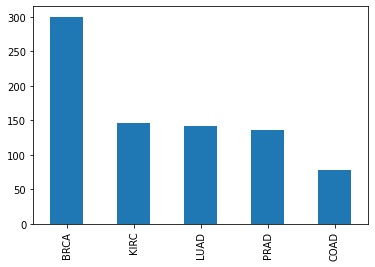

In [17]:
labels['Class'].value_counts().plot.bar()

In [24]:
label_encoder = LabelEncoder()
label_encoder.fit(labels[:,1])
labels_encoded = label_encoder.transform(labels)
labels = labels_encoded.classes_
classes = np.unique(labels)


TypeError: ignored